In [1]:
! pip install nltk

In [2]:
! pip install gensim

In [3]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import gensim
import numpy as np
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

On importe les librairie necessaire


In [4]:

data = pd.read_csv("SMSSpamCollection.txt", sep='\t', header=None)
data.columns = ['label', 'Content']
data

,label,Content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Importation du jeu de donner + transformation en DF et nommage des colonnes


In [5]:

en_stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()


Création de en_stopword pour enlever les stop word en englais dans le texte
en utilisant le stemmer

In [6]:
data['Content_len'] = data['Content'].apply(lambda x: len(x) - x.count(" "))


In [7]:

def count_punctuation(text):
    binary_array = [1 for ch in text if ch in string.punctuation]
    nb_ponctuation = sum(binary_array)
    total = len(text) - text.count(" ")
    return round(nb_ponctuation/(total), 4)*100

In [8]:
data['punctuation_rate'] = data['Content'].apply(lambda x: count_punctuation(x))

In [9]:

def clean_email(email):
    result = "".join([word for word in email if word not in string.punctuation])
    tokens = re.split('\W+', result)
    text = [ps.stem(word) for word in tokens if word not in en_stopwords]
    return text

In [10]:

def tokenize_text(text):
    tokens = re.findall('\w+', text)
    return tokens

In [11]:
def document_vectorizer(tokens, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

In [12]:
data['tokens'] = data['Content'].apply(lambda x: tokenize_text(x.lower()))


In [13]:

vectorisation_full = TfidfVectorizer(analyzer=clean_email)
vect_final = vectorisation_full.fit_transform(data['Content'])


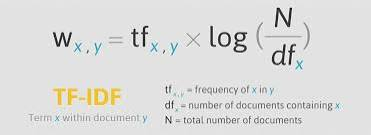

In [14]:
all_data = pd.concat([pd.DataFrame(vect_final.toarray()), data['Content_len'], data['punctuation_rate']], axis=1)

In [15]:
all_data.columns = all_data.columns.astype(str)

In [16]:
all_data

,0,1,2,3,4,5,6,7,8,9,...,8185,8186,8187,8188,8189,8190,8191,8192,Content_len,punctuation_rate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,92,9.78
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,24,25.00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,128,4.69
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,39,15.38
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,49,4.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,131,6.11
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.311086,0.0,0.0,29,3.45
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,48,14.58
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,100,1.00


In [17]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split


In [18]:
X_train, X_test, y_train, y_test = train_test_split(all_data, data['label'], test_size=0.2)


In [19]:
from sklearn import svm

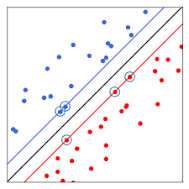

In [20]:
algo_svm = svm.SVC(kernel = 'linear')

In [21]:
algo_svm.fit(X_train, y_train)

SVC(kernel='linear')

In [22]:
predictions = algo_svm.predict(X_test)

In [23]:
len(predictions[predictions == "spam"])

140

In [24]:
len(y_test[y_test =="spam"])

148

In [25]:
len(predictions)

1115

In [26]:
precision, recall, fscore, _ = score(y_test,predictions, pos_label='spam', average='binary')

In [27]:
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3),
                                                        round(recall, 3),
                                                        round((predictions==y_test).sum() / len(predictions),3)))

Precision: 0.964 / Recall: 0.912 / Accuracy: 0.984


In [28]:
F1 = 2 * (precision * recall) / (precision + recall)
print('F1: {}'.format(round(F1,3)))

F1: 0.938


In [29]:
from gensim.models import Word2Vec
word2vec_model = Word2Vec(sentences=data['tokens'], vector_size=100, window=5, min_count=1, workers=4)

data['word2vec_features'] = data['tokens'].apply(lambda x: document_vectorizer(x, word2vec_model))
word2vec_features = pd.DataFrame(data['word2vec_features'].tolist(), index=data.index)

# Combine features
all_data = pd.concat([word2vec_features, data['Content_len'], data['punctuation_rate']], axis=1)

In [30]:
all_data

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,Content_len,punctuation_rate
0,-0.195391,0.258082,0.097665,0.144104,-0.009398,-0.620519,0.220252,0.802504,-0.375138,-0.288603,...,0.242699,0.099997,0.535824,0.314679,0.215721,-0.284201,0.075660,-0.044139,92,9.78
1,-0.166005,0.253670,0.094261,0.116492,-0.005020,-0.558578,0.202246,0.728142,-0.360836,-0.254240,...,0.214287,0.076709,0.478393,0.273439,0.198591,-0.262279,0.071756,-0.050183,24,25.00
2,-0.231586,0.297874,0.103745,0.158016,-0.000594,-0.715783,0.250423,0.927490,-0.439235,-0.321227,...,0.285742,0.101803,0.602287,0.351156,0.257965,-0.335473,0.093351,-0.039759,128,4.69
3,-0.267289,0.392355,0.145249,0.185909,-0.013963,-0.877840,0.328207,1.158370,-0.560531,-0.391173,...,0.344942,0.117968,0.755392,0.428798,0.321567,-0.407172,0.111690,-0.079351,39,15.38
4,-0.240309,0.346938,0.128576,0.174328,-0.019073,-0.783431,0.301897,1.035755,-0.484509,-0.359319,...,0.308359,0.097197,0.688074,0.407125,0.286942,-0.340048,0.083261,-0.062947,49,4.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,-0.293817,0.363945,0.126370,0.203470,0.000028,-0.886801,0.308297,1.144016,-0.537004,-0.403484,...,0.349395,0.142241,0.752053,0.438235,0.313095,-0.410057,0.111910,-0.048892,131,6.11
5568,-0.260381,0.373509,0.135630,0.195798,-0.008433,-0.860516,0.305478,1.120302,-0.541297,-0.394253,...,0.333615,0.123784,0.734083,0.417906,0.300583,-0.394540,0.107994,-0.067065,29,3.45
5569,-0.284553,0.366736,0.136012,0.209505,-0.007548,-0.883823,0.324619,1.149143,-0.528382,-0.422582,...,0.344744,0.147717,0.770441,0.459689,0.299189,-0.392738,0.099660,-0.059575,48,14.58
5570,-0.299511,0.400081,0.145164,0.219139,-0.014982,-0.946423,0.346468,1.231553,-0.573873,-0.442081,...,0.368623,0.142408,0.823169,0.482914,0.324221,-0.420556,0.106415,-0.065183,100,1.00


In [31]:

random_row = data.sample(1)

random_word = np.random.choice(random_row['tokens'].values[0])

similar_words = word2vec_model.wv.most_similar(positive=[random_word], topn=5)

print(f"Mot choisi au hasard : {random_word}\n")
print("Top 5 des mots similaires :")
for word, prob in similar_words:
    print(f"{word}: {prob:.5}")


Mot choisi au hasard : t

Top 5 des mots similaires :
me: 0.99778
when: 0.99768
tell: 0.99758
if: 0.99756
know: 0.99753


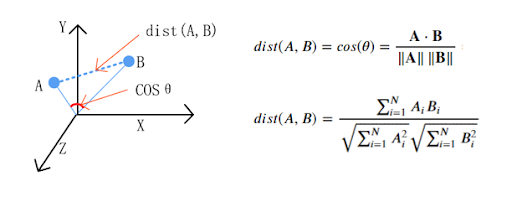